## Denisse Garnica Sánchez

El objetivo de MADE es estimar una distribución a partir de un conjunto de ejemplos. Cada entrada solo se puede reconstruir a partir de las entradas anteriores las cuales estan dadas un orden especifico. 

Importamos varias librerias que se usaran. En particular use la libreria de torch pues la implementacion que tenemos del MADE esta usando esta libreria.

In [1]:
#esta linea es por que me salia un error 
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

# Importacion y preparacion de datos

Fashion-MNIST es un conjunto de datos de imágenes muy similares a MNIST. Minetras que MNIST contiene muchos dígitos escritos a mano, Fashion-MNIST contiene imagenes de ropa. MNIST suele usarse para probar con casi cualquier red, pero probarlo con Fashion-MNIST es ligeramente mas complicado. Este cpnjunto tiene 60 000 ejemplos y un conjunto de prueba de 10 000 ejemplos. Cada ejemplo es una imagen en escala de grises de 28x28, asociada con una etiqueta de 10 clases.

Cargamos los datos. Se esta usando el dataset de Fashion Mnist el cual son imagenes de 28x28 pixeles.

In [3]:
train = datasets.FashionMNIST("", train = True, download = True,
                             transform = transforms.Compose([transforms.ToTensor()]))
test = datasets.FashionMNIST("", train = False, download = True,
                             transform = transforms.Compose([transforms.ToTensor()]))

In [4]:
trainloader =  torch.utils.data.DataLoader(train, batch_size = 64)
testloader =  torch.utils.data.DataLoader(test, batch_size = 64, shuffle =  True)

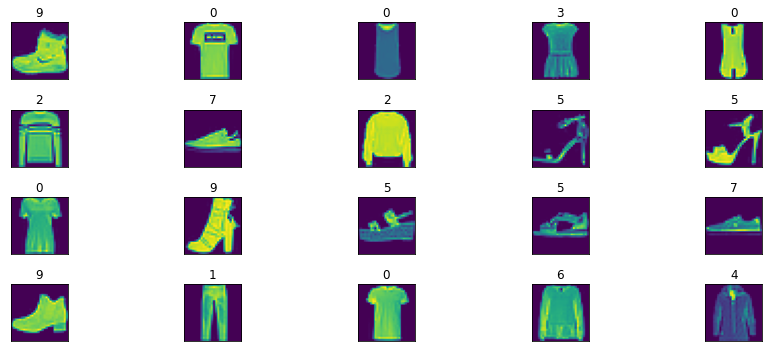

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

fig = figure(figsize=(15,5))
for idx in np.arange(20):
    ax = fig.add_subplot(4, int(20/4), idx+1, xticks = [], yticks = [])
    ax.imshow(np.squeeze(images[idx])) #,cmap = 'gray'
    ax.set_title(labels[idx].item())
    fig.tight_layout()

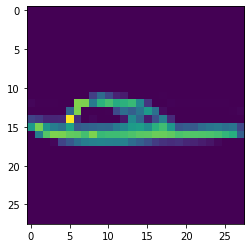

In [6]:
#Para ver una sola muestra
num_imagen = 30
plt.imshow(torch.squeeze(images[num_imagen][0]))

# MADE

Usaremos la implementacion de Andrej Karpathy la cual se encuentra en https://github.com/karpathy/pytorch-made/blob/master/made.py.

In [7]:
class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

In [8]:
class MADE(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, num_masks=1, natural_ordering=False):
        """
        nin: integer; number of inputs
        hidden sizes: a list of integers; number of units in hidden layers
        nout: integer; number of outputs, which usually collectively parameterize some kind of 1D distribution
              note: if nout is e.g. 2x larger than nin (perhaps the mean and std), then the first nin
              will be all the means and the second nin will be stds. i.e. output dimensions depend on the
              same input dimensions in "chunks" and should be carefully decoded downstream appropriately.
              the output of running the tests for this file makes this a bit more clear with examples.
        num_masks: can be used to train ensemble over orderings/connections
        natural_ordering: force natural ordering of dimensions, don't use random permutations
        """
        
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        assert self.nout % self.nin == 0, "nout must be integer multiple of nin"
        
        # define a simple MLP neural net
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop() # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net)
        
        # seeds for orders/connectivities of the model ensemble
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = 0 # for cycling through num_masks orderings
        
        self.m = {}
        self.update_masks() # builds the initial self.m connectivity
        # note, we could also precompute the masks and cache them, but this
        # could get memory expensive for large number of masks.
        
    def update_masks(self):
        if self.m and self.num_masks == 1: return # only a single seed, skip for efficiency
        L = len(self.hidden_sizes)
        
        # fetch the next seed and construct a random stream
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        
        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])
        
        # construct the mask matrices
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        # handle the case where nout = nin * k, for integer k > 1
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            # replicate the mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)
        
        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        return self.net(x)

In [9]:
def loss_function(recon_x, x):
    return F.binary_cross_entropy(
        recon_x, x.view(-1, 28*28), reduction='sum')

Ahora creamos una funcion que nos corra una epoca de la red.

In [10]:
model = MADE(28*28,[200, 200], 28*28, num_masks=30,natural_ordering=True)
optimizer = optim.Adam(model.parameters())

In [11]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(trainloader):
        data = data.view(-1, 28*28)
        batch_size = data.size(0)
        labels = torch.zeros(batch_size, 10)
        for i in range(len(label)):
            labels[i][label[i]] = 1
        data_with_label = torch.cat((labels, data), dim=1)
        optimizer.zero_grad()
        recon_data = model(data_with_label)
        loss = loss_function(recon_data, data)
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(trainloader.dataset)
    ))

In [12]:
train(1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x794 and 784x200)

# Completar imagenes

In [13]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(testloader):
            data = data.view(-1, 28*28)
            batch_size = data.size(0)
            labels = torch.zeros(batch_size, 10)
            for i in range(len(label)):
                labels[i][label[i]] = 1
            data_with_label = torch.cat((labels, data), dim=1)
            recon_data = model(data_with_label)
            cur_loss = loss_function(recon_data, data).item()
            test_loss += cur_loss
            if batch_idx == 0 and epoch == 0:
                num_samples = 8
                comparison = torch.cat(
                    [data.view(1, 28, 28)[:num_samples], recon_data.view(1, 28, 28)[:num_samples]])

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [14]:
test(1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x794 and 784x200)